# Install and Import Dependencies

### Install softwares w/ conda and pip

In [ ]:
#!/usr/bin/env python3

In [1]:
#pip install opencv-python matplotlib imageio gdown tensorflow

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
#!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.w

In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from numba import njit
import gdown

### Prevent exponential memory growth

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
#physical_devices = tf.config.list_physical_devices('GPU')
#try:
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#except:
#    pass

# Build Data Loading Function

### Download and Extract Files

In [6]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')


Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=9a808515-fa70-4a1a-bda5-3a10c0f0f3fc
To: /home/m245034/projects/LipNet/Jupyter Notebook/data.zip
100%|████████████████████████████████████████| 423M/423M [00:17<00:00, 23.6MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

### Data Loading Function

In [7]:
# turn video into usable data
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #isolates mouth use Dlib to isolate mouth to update
        frames.append(frame[190:236, 80:220,:])        
    cap.release()
    
    #help focus on vital data
    mean = tf.math.reduce_mean(frames)
    std =tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames-mean), tf.float32) / std

In [8]:
# all available charcters
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
#convert text to num and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
#use alignments

def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        #ignore silence value
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
#load alignements and videos simultaneously

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


### Test Code

In [12]:
test_path = './data/s1/bbal6n.mpg'

In [13]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [14]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
max_frame=len(frames)



In [15]:
#largest frame for imshow
print(str(max_frame-1))

74


In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [17]:
# characters from data
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
#condensed words from data
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

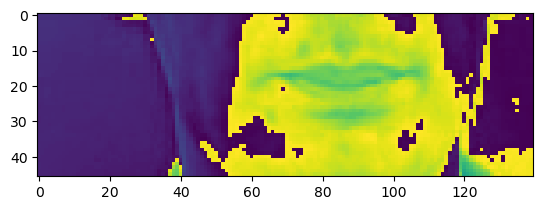

In [18]:
# image
plt.imshow(frames[20])

In [19]:
def mappable_function(path:str) ->List[str]:
    #tensorflow for pure string processing needs py_function
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result


# Create Data Pipeline

In [20]:
#make dataset
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
#shuffle data
data = data.shuffle(500, reshuffle_each_iteration=False)
#transfer data through pipeline and get it back
data = data.map(mappable_function)
#ensure 75 frames and 40 tokens
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
#optimizng preloading data
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [21]:
frames, alignments = data.as_numpy_iterator().next()

### Test

In [22]:
#test to see that the data is padded
alignments

array([[ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39, 14, 39, 26,
         5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  7, 18,  5,  5, 14, 39,  2, 25, 39,  3, 39,  5,
         9,  7,  8, 20, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [23]:
#test
sample = data.as_numpy_iterator()

In [24]:
val =sample.next(); val[0]

array([[[[[1.4007416 ],
          [1.4007416 ],
          [1.436658  ],
          ...,
          [0.25141516],
          [0.46691388],
          [0.43099743]],

         [[1.4007416 ],
          [1.4007416 ],
          [1.436658  ],
          ...,
          [9.086863  ],
          [0.17958225],
          [0.0718329 ]],

         [[1.3289087 ],
          [1.3289087 ],
          [1.3289087 ],
          ...,
          [8.979113  ],
          [9.158695  ],
          [8.943196  ]],

         ...,

         [[0.9697442 ],
          [0.9697442 ],
          [0.93382776],
          ...,
          [9.158695  ],
          [0.1436658 ],
          [0.        ]],

         [[0.9697442 ],
          [0.9697442 ],
          [0.93382776],
          ...,
          [9.015029  ],
          [9.158695  ],
          [9.050946  ]],

         [[0.9697442 ],
          [0.9697442 ],
          [0.93382776],
          ...,
          [9.050946  ],
          [0.10774936],
          [9.122779  ]]],


        [[[1.3648

In [25]:
#changes dataset into a gif 
#can change 2nd number value to either 0 or 1
fv=(val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif',fv, duration=50)

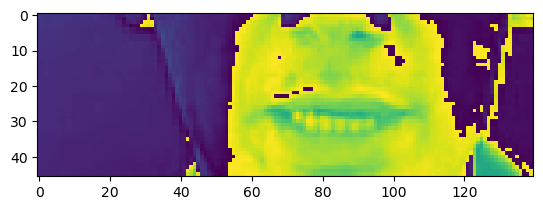

In [26]:
#plots out the image
# videos, 1st vid out of batch, return first frame in the video
plt.imshow(val[0][0][30])

In [27]:
samp=val[1][1]
sam=val[1][0]

In [28]:
num_to_char(samp)


<tf.Tensor: shape=(40,), dtype=string, numpy=
array([b's', b'e', b't', b' ', b'r', b'e', b'd', b' ', b'a', b't', b' ',
       b'b', b' ', b't', b'h', b'r', b'e', b'e', b' ', b'a', b'g', b'a',
       b'i', b'n', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b''], dtype=object)>

In [29]:
print([bytes.decode(x) for x in num_to_char(samp).numpy()])

['s', 'e', 't', ' ', 'r', 'e', 'd', ' ', 'a', 't', ' ', 'b', ' ', 't', 'h', 'r', 'e', 'e', ' ', 'a', 'g', 'a', 'i', 'n', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [30]:
#decodes gif
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])
#print[tf.strings.reduce_join([num_to_char(word) for word in val[]

#condensed words from data
#tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
# characters from data
#print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red at b three again'>

# Design Deep Neural Network


In [31]:
#import more dependencies
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [32]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [33]:
model = Sequential()
# 3 sets of convulusions
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#flatten convulsions w/ timedistrubted layer
model.add(TimeDistributed(Flatten()))

#Two sets of LSTMs
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Dense Layer
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [35]:
#testing [predictions data]
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [37]:
#the predicted output in charactesr
sam=tf.argmax(yhat[0],axis=1)
print([bytes.decode(x) for x in num_to_char(sam).numpy()])

['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i']


# Training Setup and Train


In [38]:
# define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [39]:
#define CTC loss
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [40]:
class ProduceExample(tf.keras.callbacks.Callback):
    
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [41]:
#Compiles our model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

### Define Callbacks

In [42]:
#Save model checkpoints
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [43]:
#Scheulder should drop the learning rate
schedule_callback = LearningRateScheduler(scheduler)

In [44]:
#make predictions after each epoch
example_callback = ProduceExample(test)

In [47]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
299/450 [==================>...........] - ETA: 33:56 - loss: 71.8518

[mpeg1video @ 0x7f6490007e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6490007e80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.9267 

[mpeg1video @ 0x7f6490021c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6490021c40] Warning MVs not available
[mpeg1video @ 0x7f651cbbdac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f651cbbdac0] Warning MVs not available


1/1 [==============================] - 10s 10s/step
Original: lay red by l three again
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white with m one soon
Prediction: la e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 8600s 19s/step - loss: 70.9267 - val_loss: 64.3995 - lr: 1.0000e-04
Epoch 2/100
309/450 [===================>..........] - ETA: 31:27 - loss: 67.3012

[mpeg1video @ 0x7f65140c9f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65140c9f00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.8887 

[mpeg1video @ 0x7f65b8097140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65b8097140] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: set white with j one again
Prediction: la e e i e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green in q four please
Prediction: la e e i e an
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 5751s 13s/step - loss: 66.8887 - val_loss: 62.0686 - lr: 1.0000e-04
Epoch 3/100
363/450 [=======================>......] - ETA: 12:26 - loss: 64.0898

[mpeg1video @ 0x7f64a0008640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64a0008640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.0259

[mpeg1video @ 0x7f64d4007a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64d4007a40] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay white with s five soon
Prediction: la e e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by k zero now
Prediction: la e e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4270s 9s/step - loss: 64.0259 - val_loss: 58.9100 - lr: 1.0000e-04
Epoch 4/100
161/450 [=========>....................] - ETA: 41:17 - loss: 62.5514

[mpeg1video @ 0x7f6544002380] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6544002380] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.0040

[mpeg1video @ 0x7f64700046c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64700046c0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin red at f nine soon
Prediction: la re t e eao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with a four please
Prediction: la re t e eao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4240s 9s/step - loss: 62.0040 - val_loss: 58.2349 - lr: 1.0000e-04
Epoch 5/100
 30/450 [=>............................] - ETA: 59:51 - loss: 61.1029 

[mpeg1video @ 0x7f64c80074c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64c80074c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 60.4471

[mpeg1video @ 0x7f653c11e540] ac-tex damaged at 22 17
[mpeg1video @ 0x7f653c11e540] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin green by h five soon
Prediction: la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red with k one again
Prediction: la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4240s 9s/step - loss: 60.4471 - val_loss: 56.7632 - lr: 1.0000e-04
Epoch 6/100
410/450 [==========================>...] - ETA: 5:41 - loss: 58.8400

[mpeg1video @ 0x7f64680331c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64680331c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 58.8147

[mpeg1video @ 0x7f64c8086600] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64c8086600] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set blue in g seven again
Prediction: la re t e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with r five soon
Prediction: la re t e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4243s 9s/step - loss: 58.8147 - val_loss: 54.4352 - lr: 1.0000e-04
Epoch 7/100
395/450 [=========================>....] - ETA: 7:50 - loss: 55.5879

[mpeg1video @ 0x7f6534018680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6534018680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 55.6126

[mpeg1video @ 0x7f65b8097140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65b8097140] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set red with b nine soon
Prediction: la re t e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red by t one soon
Prediction: la re i e a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4239s 9s/step - loss: 55.6126 - val_loss: 52.1232 - lr: 1.0000e-04
Epoch 8/100
346/450 [======================>.......] - ETA: 14:47 - loss: 53.7402

[mpeg1video @ 0x7f64c0087780] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64c0087780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 53.5368

[mpeg1video @ 0x7f651d3d7280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f651d3d7280] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set blue in g six please
Prediction: la re t e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white at u eight now
Prediction: la re t e aon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4224s 9s/step - loss: 53.5368 - val_loss: 49.7009 - lr: 1.0000e-04
Epoch 9/100
276/450 [=================>............] - ETA: 24:49 - loss: 52.0561

[mpeg1video @ 0x7f65c4061f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65c4061f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.8891

[mpeg1video @ 0x7f64b0127000] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64b0127000] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay green with t one soon
Prediction: la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green with j five soon
Prediction: la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4246s 9s/step - loss: 51.8891 - val_loss: 48.3286 - lr: 1.0000e-04
Epoch 10/100
414/450 [==========================>...] - ETA: 5:07 - loss: 50.4557

[mpeg1video @ 0x7f65340457c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65340457c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 50.4314

[mpeg1video @ 0x7f65bc122dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65bc122dc0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin blue at z five soon
Prediction: la re t ie o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white by o nine soon
Prediction: la re i e ao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4236s 9s/step - loss: 50.4314 - val_loss: 45.5264 - lr: 1.0000e-04
Epoch 11/100
194/450 [===========>..................] - ETA: 36:23 - loss: 49.0773

[mpeg1video @ 0x7f64a0035780] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64a0035780] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 48.6138

[mpeg1video @ 0x7f6510143080] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6510143080] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay white at r eight please
Prediction: la re it e a
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green by u four please
Prediction: la re t e ae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4255s 9s/step - loss: 48.6138 - val_loss: 44.9920 - lr: 1.0000e-04
Epoch 12/100
289/450 [==================>...........] - ETA: 23:02 - loss: 47.0338

[mpeg1video @ 0x7f65c00966c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65c00966c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 46.8982

[mpeg1video @ 0x7f64a4023e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64a4023e40] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay blue by r zero please
Prediction: la re b e lae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with e eight please
Prediction: la re i ie lase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4272s 9s/step - loss: 46.8982 - val_loss: 43.7604 - lr: 1.0000e-04
Epoch 13/100
 64/450 [===>..........................] - ETA: 55:20 - loss: 45.9902

[mpeg1video @ 0x7f64fc0cee40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64fc0cee40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 45.0586

[mpeg1video @ 0x7f65bc008580] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65bc008580] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place blue in i three again
Prediction: la re it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red in c two now
Prediction: la re it oe o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4268s 9s/step - loss: 45.0586 - val_loss: 40.7831 - lr: 1.0000e-04
Epoch 14/100
 36/450 [=>............................] - ETA: 59:27 - loss: 43.2656

[mpeg1video @ 0x7f648808df00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f648808df00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 43.3497

[mpeg1video @ 0x7f64fc0a0f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64fc0a0f00] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: set green with j six please
Prediction: pla re it e plase
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at i seven again
Prediction: plac bre it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4278s 10s/step - loss: 43.3497 - val_loss: 37.7473 - lr: 1.0000e-04
Epoch 15/100
142/450 [========>.....................] - ETA: 44:06 - loss: 41.3637

[mpeg1video @ 0x7f65b007aa80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65b007aa80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 41.1511

[mpeg1video @ 0x7f6478128780] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6478128780] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay green at s four please
Prediction: bla re it ir plese
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue with m seven again
Prediction: plac blue by ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4269s 9s/step - loss: 41.1511 - val_loss: 35.1652 - lr: 1.0000e-04
Epoch 16/100
 39/450 [=>............................] - ETA: 59:23 - loss: 37.7514

[mpeg1video @ 0x7f64f0078a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64f0078a00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.6824

[mpeg1video @ 0x7f652c01dac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f652c01dac0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set blue with u five soon
Prediction: pla blue it oe son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at z three again
Prediction: sit wre it ie ain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4273s 9s/step - loss: 38.6824 - val_loss: 34.8811 - lr: 1.0000e-04
Epoch 17/100
113/450 [======>.......................] - ETA: 48:10 - loss: 37.0396

[mpeg1video @ 0x7f64940cb840] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64940cb840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 36.4127

[mpeg1video @ 0x7f64cc08bb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64cc08bb40] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place white with k four now
Prediction: lac re it o now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in r seven soon
Prediction: plac blue it se son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4284s 10s/step - loss: 36.4127 - val_loss: 31.2532 - lr: 1.0000e-04
Epoch 18/100


[mpeg1video @ 0x7f655406d6c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f655406d6c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 34.3330

[mpeg1video @ 0x7f6478019100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6478019100] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set green in i two now
Prediction: set re it o now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with c nine soon
Prediction: pla blue it e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4313s 10s/step - loss: 34.3330 - val_loss: 29.9520 - lr: 1.0000e-04
Epoch 19/100
450/450 [==============================] - ETA: 0s - loss: 32.2655

[mpeg1video @ 0x7f651cd2e000] ac-tex damaged at 22 17
[mpeg1video @ 0x7f651cd2e000] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set blue at t eight please
Prediction: pla blue it ie please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with h three soon
Prediction: set white it e son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4266s 9s/step - loss: 32.2655 - val_loss: 26.9215 - lr: 1.0000e-04
Epoch 20/100
393/450 [=========================>....] - ETA: 8:10 - loss: 29.7414

[mpeg1video @ 0x140879c0] ac-tex damaged at 22 17
[mpeg1video @ 0x140879c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 29.6423

[mpeg1video @ 0x7f64c8094400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64c8094400] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set white in b two now
Prediction: set re it wo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red with v zero now
Prediction: set red wit o now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4268s 9s/step - loss: 29.6423 - val_loss: 24.6345 - lr: 1.0000e-04
Epoch 21/100
225/450 [==============>...............] - ETA: 32:19 - loss: 27.5001

[mpeg1video @ 0x7f65181242c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65181242c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 27.3594

[mpeg1video @ 0x7f65cc160dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65cc160dc0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place white in d one again
Prediction: place bhite at ne again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at a five soon
Prediction: blt blue it ie son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4273s 9s/step - loss: 27.3594 - val_loss: 22.4178 - lr: 1.0000e-04
Epoch 22/100
450/450 [==============================] - ETA: 0s - loss: 25.0324

[mpeg1video @ 0x7f652a269280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f652a269280] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place red by j four now
Prediction: place re by or now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by x zero please
Prediction: set red by eo please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4251s 9s/step - loss: 25.0324 - val_loss: 18.7418 - lr: 1.0000e-04
Epoch 23/100
349/450 [======================>.......] - ETA: 14:32 - loss: 23.1591

[mpeg1video @ 0x7f65b809cf40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65b809cf40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.9625

[mpeg1video @ 0x7f64a0078640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64a0078640] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay white at r seven soon
Prediction: lay white at sve son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by h three soon
Prediction: set blue bt te son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4293s 10s/step - loss: 22.9625 - val_loss: 18.2497 - lr: 1.0000e-04
Epoch 24/100
 93/450 [=====>........................] - ETA: 51:10 - loss: 20.6165

[mpeg1video @ 0x7f651e090c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f651e090c00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 21.0431

[mpeg1video @ 0x7f65b40b4740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65b40b4740] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin blue with t one again
Prediction: bin blue it ne again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at u two now
Prediction: set red at wo now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4264s 9s/step - loss: 21.0431 - val_loss: 15.9139 - lr: 1.0000e-04
Epoch 25/100
376/450 [========================>.....] - ETA: 10:38 - loss: 19.1565

[mpeg1video @ 0x7f6498001680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6498001680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.1527

[mpeg1video @ 0x7f64ec043b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64ec043b40] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay blue in x six please
Prediction: lay blue in six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white in p six now
Prediction: place white in six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4282s 10s/step - loss: 19.1527 - val_loss: 14.1608 - lr: 1.0000e-04
Epoch 26/100
313/450 [===================>..........] - ETA: 19:35 - loss: 18.1410

[mpeg1video @ 0x7f65c00acc80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65c00acc80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 17.9072

[mpeg1video @ 0x7f64940c8280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64940c8280] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay white in l one again
Prediction: lay white in one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green with u eight please
Prediction: bin gren with eigh please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4267s 9s/step - loss: 17.9072 - val_loss: 13.5342 - lr: 1.0000e-04
Epoch 27/100
355/450 [======================>.......] - ETA: 13:35 - loss: 16.8446

[mpeg1video @ 0x7f64f4127800] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64f4127800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 16.6758

[mpeg1video @ 0x7f654c0a7c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f654c0a7c00] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay red with s zero please
Prediction: lay red wit zor please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in z six now
Prediction: bin ren in six now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4266s 9s/step - loss: 16.6758 - val_loss: 12.0434 - lr: 1.0000e-04
Epoch 28/100
106/450 [======>.......................] - ETA: 49:19 - loss: 15.9493

[mpeg1video @ 0x7f6490086a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6490086a40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.3300

[mpeg1video @ 0x7f64e40083c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64e40083c0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin green with o three soon
Prediction: bin gren with hre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red with j nine soon
Prediction: place red with ine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4278s 10s/step - loss: 15.3300 - val_loss: 10.6504 - lr: 1.0000e-04
Epoch 29/100
  1/450 [..............................] - ETA: 1:20:18 - loss: 11.9860

[mpeg1video @ 0x7f65a80f8b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65a80f8b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.6734

[mpeg1video @ 0x7f6490013d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6490013d00] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set green with q zero please
Prediction: set gren with zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red by i zero please
Prediction: set gred by ero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4266s 9s/step - loss: 14.6734 - val_loss: 10.4144 - lr: 1.0000e-04
Epoch 30/100
402/450 [=========================>....] - ETA: 7:18 - loss: 13.3709

[mpeg1video @ 0x7f64dc005680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64dc005680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.3706

[mpeg1video @ 0x7f654409c480] ac-tex damaged at 22 17
[mpeg1video @ 0x7f654409c480] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay green at s two now
Prediction: lay gren at two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue with j three soon
Prediction: place blue with hre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4752s 11s/step - loss: 13.3706 - val_loss: 9.6499 - lr: 1.0000e-04
Epoch 31/100
146/450 [========>.....................] - ETA: 50:47 - loss: 12.3480

[mpeg1video @ 0x7f64800b5ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64800b5ac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.3310

[mpeg1video @ 0x7f64d40a1f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64d40a1f40] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay red by e eight please
Prediction: lay red by eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with e two please
Prediction: place white with two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4656s 10s/step - loss: 12.3310 - val_loss: 8.8368 - lr: 9.0484e-05
Epoch 32/100
 59/450 [==>...........................] - ETA: 56:07 - loss: 11.9739

[mpeg1video @ 0x7f6548021f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6548021f40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.5217

[mpeg1video @ 0x7f64840d4200] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64840d4200] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set white at i three again
Prediction: set white at thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at n five again
Prediction: set blue at five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4268s 9s/step - loss: 11.5217 - val_loss: 8.1700 - lr: 8.1873e-05
Epoch 33/100
121/450 [=======>......................] - ETA: 47:17 - loss: 10.6246

[mpeg1video @ 0x7f64d008ef40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64d008ef40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.6741

[mpeg1video @ 0x7f653c029e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f653c029e00] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin green by b three again
Prediction: bin gren by thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in s four please
Prediction: bin red in fou please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4277s 10s/step - loss: 10.6741 - val_loss: 7.2713 - lr: 7.4082e-05
Epoch 34/100
110/450 [======>.......................] - ETA: 48:47 - loss: 10.0208

[mpeg1video @ 0x1492b740] ac-tex damaged at 22 17
[mpeg1video @ 0x1492b740] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.9449

[mpeg1video @ 0x7f64d0099e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64d0099e80] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin red by t two please
Prediction: bin red by two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by p five soon
Prediction: set gren by five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4267s 9s/step - loss: 9.9449 - val_loss: 6.8556 - lr: 6.7032e-05
Epoch 35/100
450/450 [==============================] - ETA: 0s - loss: 9.4712

[mpeg1video @ 0x7f65c4025bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65c4025bc0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin green with u nine again
Prediction: bin gren with ne again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with k six please
Prediction: place white with six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4266s 9s/step - loss: 9.4712 - val_loss: 6.3395 - lr: 6.0653e-05
Epoch 36/100
257/450 [================>.............] - ETA: 27:33 - loss: 9.1598

[mpeg1video @ 0x7f64bc1598c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64bc1598c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.0828

[mpeg1video @ 0x7f652001c040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f652001c040] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin blue at s zero now
Prediction: bin blue at zero now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white in u seven again
Prediction: set white in seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4265s 9s/step - loss: 9.0828 - val_loss: 5.8106 - lr: 5.4881e-05
Epoch 37/100
324/450 [====================>.........] - ETA: 18:10 - loss: 8.5251

[mpeg1video @ 0x7f65bc125340] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65bc125340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.5356

[mpeg1video @ 0x7f64ac011980] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64ac011980] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set white by i five soon
Prediction: set white by i five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white at z two please
Prediction: lay white at two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4293s 10s/step - loss: 8.5356 - val_loss: 5.3695 - lr: 4.9659e-05
Epoch 38/100
361/450 [=======================>......] - ETA: 12:49 - loss: 7.9932

[mpeg1video @ 0x7f650c0f3ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f650c0f3ec0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.9817

[mpeg1video @ 0x7f65c012ecc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65c012ecc0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin red with t four now
Prediction: bin red with four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set white with i eight now
Prediction: set white with eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4305s 10s/step - loss: 7.9817 - val_loss: 5.8461 - lr: 4.4933e-05
Epoch 39/100
295/450 [==================>...........] - ETA: 22:12 - loss: 7.6884

[mpeg1video @ 0x7f64b40c7b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64b40c7b00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.6128

[mpeg1video @ 0x7f64e40064c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64e40064c0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay blue at k two please
Prediction: lay blue at two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue at l nine again
Prediction: bin blue at nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4266s 9s/step - loss: 7.6128 - val_loss: 4.6206 - lr: 4.0657e-05
Epoch 40/100
 60/450 [===>..........................] - ETA: 56:02 - loss: 7.4978

[mpeg1video @ 0x7f65c012ecc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65c012ecc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.3518

[mpeg1video @ 0x7f648c018880] ac-tex damaged at 22 17
[mpeg1video @ 0x7f648c018880] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set blue with b four please
Prediction: set blue with four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at c two now
Prediction: set gren at two now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4282s 10s/step - loss: 7.3518 - val_loss: 4.5006 - lr: 3.6788e-05
Epoch 41/100
196/450 [============>.................] - ETA: 36:36 - loss: 7.1170

[mpeg1video @ 0x7f650402e480] ac-tex damaged at 22 17
[mpeg1video @ 0x7f650402e480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.0101

[mpeg1video @ 0x7f65a4002640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65a4002640] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay white in r four please
Prediction: lay white in four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in f six please
Prediction: bin red in six please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4307s 10s/step - loss: 7.0101 - val_loss: 4.2387 - lr: 3.3287e-05
Epoch 42/100
  5/450 [..............................] - ETA: 1:04:30 - loss: 7.2310

[mpeg1video @ 0x7f6488066ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6488066ac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.7632

[mpeg1video @ 0x7f64d001d8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64d001d8c0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin white in m five soon
Prediction: bin white in five son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white by t seven soon
Prediction: bin white by seven son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4265s 9s/step - loss: 6.7632 - val_loss: 4.0011 - lr: 3.0119e-05
Epoch 43/100
196/450 [============>.................] - ETA: 36:29 - loss: 6.4328

[mpeg1video @ 0x7f65540a53c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f65540a53c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.5043

[mpeg1video @ 0x7f6478019100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6478019100] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: bin blue in l four please
Prediction: bin blue in four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in a three soon
Prediction: bin gren in a thre son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4269s 9s/step - loss: 6.5043 - val_loss: 3.7947 - lr: 2.7253e-05
Epoch 44/100
 24/450 [>.............................] - ETA: 1:00:55 - loss: 6.0526

[mpeg1video @ 0x7f64f8036480] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64f8036480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.1191

[mpeg1video @ 0x7f652c02d280] ac-tex damaged at 22 17
[mpeg1video @ 0x7f652c02d280] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place green by y seven again
Prediction: place gren by y seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in o four now
Prediction: place blue in o four now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4266s 9s/step - loss: 6.1191 - val_loss: 3.4800 - lr: 2.4660e-05
Epoch 45/100
406/450 [==========================>...] - ETA: 6:18 - loss: 5.9299

[mpeg1video @ 0x7f6494041b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6494041b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.9432

[mpeg1video @ 0x7f64cc0850c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64cc0850c0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: lay red in y three again
Prediction: lay red in thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white with y five again
Prediction: place white with y five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4281s 10s/step - loss: 5.9432 - val_loss: 3.2493 - lr: 2.2313e-05
Epoch 46/100
266/450 [================>.............] - ETA: 26:50 - loss: 5.8897

[mpeg1video @ 0x7f654c065cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f654c065cc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.8450

[mpeg1video @ 0x7f64800a64c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64800a64c0] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: place white in d zero please
Prediction: place white in d zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red with n three again
Prediction: bin red with thre again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4317s 10s/step - loss: 5.8450 - val_loss: 3.0520 - lr: 2.0190e-05
Epoch 47/100
293/450 [==================>...........] - ETA: 22:28 - loss: 5.6077

[mpeg1video @ 0x7f64e40d9680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64e40d9680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.6494

[mpeg1video @ 0x7f652b4d4f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f652b4d4f80] Warning MVs not available


1/1 [==============================] - 3s 3s/step
Original: set white by i seven again
Prediction: set white by seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by n eight sp please
Prediction: set blue by n eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4270s 9s/step - loss: 5.6494 - val_loss: 3.4758 - lr: 1.8268e-05
Epoch 48/100
283/450 [=================>............] - ETA: 23:57 - loss: 5.4914

[mpeg1video @ 0x7f647008a400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f647008a400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.4940

[mpeg1video @ 0x7f64c4011340] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64c4011340] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: place white with k seven again
Prediction: place white with seven again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay green by f nine soon
Prediction: lay gren by nine son
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4271s 9s/step - loss: 5.4940 - val_loss: 3.2432 - lr: 1.6530e-05
Epoch 49/100
243/450 [===============>..............] - ETA: 29:41 - loss: 5.3201

[mpeg1video @ 0x7f653c0033c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f653c0033c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.3133

[mpeg1video @ 0x7f646802ca80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f646802ca80] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: bin red by m eight please
Prediction: bin red by eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue with r four please
Prediction: lay blue with four please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4274s 9s/step - loss: 5.3133 - val_loss: 2.6982 - lr: 1.4957e-05
Epoch 50/100
 30/450 [=>............................] - ETA: 59:42 - loss: 4.8649

[mpeg1video @ 0x7f64b00026c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64b00026c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.1663

[mpeg1video @ 0x7f64ec08d500] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64ec08d500] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: place blue in u eight now
Prediction: place blue in u eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin red in m one again
Prediction: bin red in one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 4274s 9s/step - loss: 5.1663 - val_loss: 2.7801 - lr: 1.3534e-05
Epoch 51/100
156/450 [=========>....................] - ETA: 42:08 - loss: 5.2008

[mpeg1video @ 0x7f6468003e80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f6468003e80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.1805

[mpeg1video @ 0x7f64a009b900] ac-tex damaged at 22 17
[mpeg1video @ 0x7f64a009b900] Warning MVs not available


StopIteration: 

# Make Prediction

In [47]:
#url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
#output = 'checkpoints.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=11c17ed4-13ee-48a1-9f98-c21682e0c161
To: /home/m245034/projects/LipNet/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:04<00:00, 22.9MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [49]:
#model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.